# Title

## Get the data using the webtris API

Import modules and write function to interact with WebTris API

In [1]:
%matplotlib inline
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
import seaborn as sns
import folium
import plotly
import plotly.offline as py
import plotly.graph_objs as go
import datetime
plotly.offline.init_notebook_mode(connected=True)

def site_info(site_id):
    """Returns a dictionary giving info on the specified site"""
    r = requests.get('http://webtris.highwaysengland.co.uk/api/v1.0/sites/' +
                     str(site_id))
    return(r.json()['sites'][0])

def site_data(site , start_date, end_date ):
    """Returns a pandas dataframe containing traffic data in 15 minute chunks.
    Dates are string of the format ddmmyyyy"""
    more_pages = True
    page_num = 1
    data = []
    # Need to go through many pages. The returned json has a nextPage item if
    # there is anothe page to collect
    while more_pages:
        r = requests.get('http://webtris.highwaysengland.co.uk/api/v1.0/reports/daily',
                         params = {'sites': str(site),
                                   'start_date': start_date,
                                   'end_date': end_date,
                                   'page': page_num,
                                   'page_size': 20000})
        json_response = r.json()
        invalid_response = 'Report Request Invalid. Please ensure all parameters are valid in line with API documentation.'
        if json_response == invalid_response:
            raise Exception('The API did not return any data. Check the site has data for the given dates' +
                            'and the arguments were supplied correctly. ' +
                            'Dates should be given as a string in ddmmyyyy format')
        for item in json_response['Rows']:
            data.append(item)
        links = [item['rel'] for item in json_response['Header']['links']]
        print('Fetched ' + str(len(data)) + ' data points')
        page_num += 1
        more_pages = 'nextPage' in links
    df = pd.DataFrame(data)
    # Make blanks -99, fill in later
    df = df.apply(lambda x: np.where(x == '', '-99', x))
    df_clean = pd.DataFrame({
        'Date': pd.to_datetime(df['Report Date']),
        'SiteId': site,
        'TotalFlow':  df['Total Volume'].astype(int),
        'LargeVehicleFlow': df['1160+ cm'].astype(int),
        'AverageSpeedMPH': df['Avg mph'].astype(int)
        })
    # Work out the start and end time of the period
    def extract_time_delta(str_time):
        hour = int(str_time.split(':')[0])
        minute = int(str_time.split(':')[1])
        offset = pd.Timedelta(hours = hour, minutes = minute)
        return(offset)
    mins_offset = [extract_time_delta(x) for x in df['Time Period Ending']]
    df_clean['EndTime'] = df_clean['Date'] + mins_offset
    df_clean['StartTime'] = df_clean['EndTime'] - pd.Timedelta(minutes = 15)
    # Make nans explicit
    df_clean.loc[df_clean['TotalFlow'] == -99 , 'TotalFlow'] = np.nan
    df_clean.loc[df_clean['LargeVehicleFlow'] == -99 , 'LargeVehicleFlow'] = np.nan
    df_clean.loc[df_clean['AverageSpeedMPH'] == -99 , 'AverageSpeedMPH'] = np.nan
    return(df_clean)

Choose a site and fetch the data
Use the map on webtris website or the API to find site numbers

In [2]:
site = 9006
start_date = '01012008'
end_date = '31122016'

In [3]:
my_site = site_info(site)
my_site

{'Description': '6180/1',
 'Id': '9006',
 'Latitude': 51.4480857515236,
 'Longitude': -0.450825028382527,
 'Name': 'TMU Site 6180/1 on link A30 eastbound between B378 and A315; GPS Ref: 507750;173260; Eastbound',
 'Status': 'Active'}

In [94]:
lat = my_site['Latitude']
lon = my_site['Longitude']
my_map = folium.Map(location=[lat, lon], zoom_start=13)
folium.Marker([lat, lon], popup = my_site['Name']).add_to(my_map)
my_map

In [5]:
 df = site_data(site, start_date, end_date)

Fetched 20000 data points
Fetched 40000 data points
Fetched 60000 data points
Fetched 80000 data points
Fetched 100000 data points
Fetched 120000 data points
Fetched 120760 data points


In [6]:
df.tail()

,AverageSpeedMPH,Date,LargeVehicleFlow,SiteId,TotalFlow,EndTime,StartTime
120755,40.0,2016-12-31,2.0,9006,45.0,2016-12-31 22:59:00,2016-12-31 22:44:00
120756,40.0,2016-12-31,2.0,9006,49.0,2016-12-31 23:14:00,2016-12-31 22:59:00
120757,41.0,2016-12-31,0.0,9006,39.0,2016-12-31 23:29:00,2016-12-31 23:14:00
120758,40.0,2016-12-31,1.0,9006,28.0,2016-12-31 23:44:00,2016-12-31 23:29:00
120759,41.0,2016-12-31,0.0,9006,30.0,2016-12-31 23:59:00,2016-12-31 23:44:00


## Plot time series of flow

### One year

In [7]:
year_start = '2014-01-01'
year_end = '2014-12-31'
one_year = df[(df.StartTime >= year_start) & (df.StartTime <= year_end)]
plot_data = [go.Scatter(x=one_year.StartTime, y=one_year.TotalFlow)]

layout = dict(
    xaxis=dict(
        rangeslider=dict(),
        type='date',
        range = ['2014-04-23','2014-05-09']))
fig = dict(data=plot_data, layout=layout)
plotly.offline.iplot(fig)

#daily_flow = df.groupby('Date')['TotalFlow'].sum()
#one_year_daily_flow = daily_flow[(daily_flow.index >= year_start) & (daily_flow.index <= year_end)]
#plot_data = [go.Scatter(x=one_year_daily_flow.index, y=one_year_daily_flow)]
#plotly.offline.iplot(plot_data)

There are some messy data

## Daily data

In [8]:
daily_flow = df.groupby('Date')['TotalFlow'].sum()
plot_data = [go.Scatter(x=daily_flow.index, y=daily_flow)]
plotly.offline.iplot(plot_data)

## Forecast future daily flow

Use the prophet packages

In [42]:
data_prophet = daily_flow[daily_flow > 2500].reset_index()
data_prophet.columns = ['ds', 'y']
m = Prophet()
m.fit(data_prophet)
future = m.make_future_dataframe(periods=365*3)
forecast = m.predict(future)
forecast.head()

,ds,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,seasonal,yhat
0,2008-01-01,0.000000,12980.583763,-1594.994981,-1594.994981,12980.583763,12980.583763,10148.736605,12558.266737,1115.314504,1115.314504,1115.314504,-2710.309485,-2710.309485,-2710.309485,-1594.994981,11385.588782
1,2008-01-02,0.000304,12979.445327,-1272.832800,-1272.832800,12979.445327,12979.445327,10481.004834,13020.288338,1403.502369,1403.502369,1403.502369,-2676.335169,-2676.335169,-2676.335169,-1272.832800,11706.612526
2,2008-01-03,0.000608,12978.306891,-1147.755552,-1147.755552,12978.306891,12978.306891,10577.486263,13093.281352,1471.128730,1471.128730,1471.128730,-2618.884282,-2618.884282,-2618.884282,-1147.755552,11830.551339
3,2008-01-04,0.000913,12977.168455,-1174.114606,-1174.114606,12977.168455,12977.168455,10577.655039,13058.970162,1365.352713,1365.352713,1365.352713,-2539.467319,-2539.467319,-2539.467319,-1174.114606,11803.053848
4,2008-01-05,0.001217,12976.030018,-4717.266281,-4717.266281,12976.030018,12976.030018,6899.940236,9501.010211,-2277.290229,-2277.290229,-2277.290229,-2439.976053,-2439.976053,-2439.976053,-4717.266281,8258.763737


In [10]:
forecast_data = forecast.loc[forecast.ds > data_prophet.ds.max(), ['ds', 'yhat_lower', 'yhat_upper', 'yhat']]
historic = go.Scatter(x=data_prophet.ds, y=data_prophet.y)
forecasted = go.Scatter(x=forecast_data.ds, y=forecast_data.yhat)
                        
plot_data = [historic,  forecasted]
plotly.offline.iplot(plot_data)

In [11]:
upper_forecast = go.Scatter(x=forecast_data.ds, y=forecast_data.yhat_upper, fill= 'tonexty', line=dict(width=0.0))
lower_forecast = go.Scatter(x=forecast_data.ds, y=forecast_data.yhat_lower, fill= None, line=dict(width=0.0))
plot_data = [forecasted, lower_forecast, upper_forecast ]

layout = dict(
    xaxis=dict(
        rangeslider=dict(),
        type='date',
        range = ['2017-01-01','2017-03-01']))
fig = dict(data=plot_data, layout=layout)
plotly.offline.iplot(fig)


## Components

In [12]:
trend = go.Scatter(x=forecast.ds, y=forecast.trend)
trend_lower = go.Scatter(x=forecast.ds, y=forecast.trend_lower, fill= None, line=dict(width=0.0))
trend_upper = go.Scatter(x=forecast.ds, y=forecast.trend_upper, fill= 'tonexty', line=dict(width=0.0))
plot_data = [trend, trend_lower, trend_upper]
plotly.offline.iplot(plot_data)


In [34]:
forecast['day_of_week'] = forecast.ds.apply(lambda x: x.weekday())
daily_trend = forecast.groupby('day_of_week')['weekly'].mean()
plot_data = go.Bar(x=['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'], y=daily_trend.values)
plotly.offline.iplot([plot_data])

In [85]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
forecast['day'] = forecast.ds.apply(lambda x: x.day)
forecast['month'] = forecast.ds.apply(lambda x: x.month)
yearly_trend = forecast.groupby(['month', 'day'])['yearly'].mean().reset_index().sort_values(['month', 'day']).reindex()
yearly_trend['label'] = yearly_trend.apply(lambda x: str(int(x.day)) + ' ' + months[int(x.month)-1], axis=1)
plot_data = go.Bar(x=yearly_trend.label.values, y=yearly_trend.yearly.values)
plotly.offline.iplot([plot_data])

# Speed flow curve

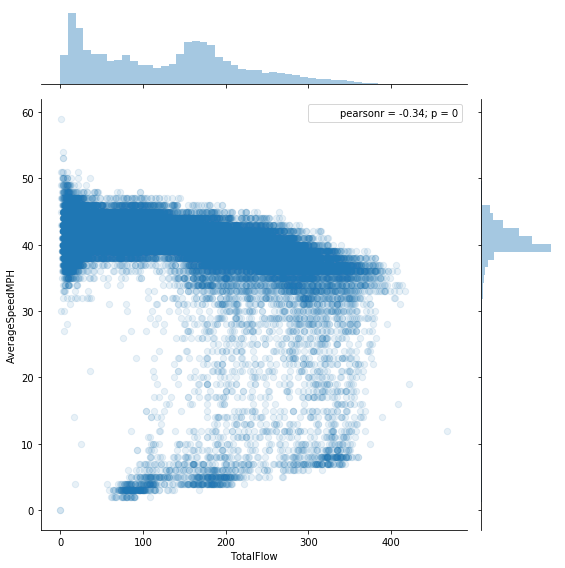

In [15]:
sns.jointplot(x="TotalFlow", y="AverageSpeedMPH", data=df, alpha = 0.1, s = 40, size = 8)